In [1]:
import gif
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import datetime
from tqdm import tqdm
from skforecast.model_selection.model_selection import _create_backtesting_folds

import warnings
warnings.filterwarnings('ignore')

## Data

,y
date,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


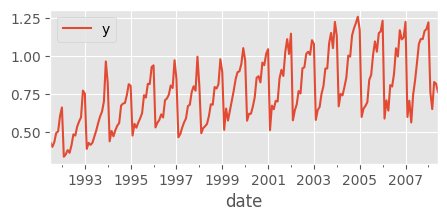

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data_gif = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data_gif['fecha'] = pd.to_datetime(data_gif['fecha'], format='%Y/%m/%d')
data_gif = data_gif.rename(columns={"fecha": "date"}, errors="raise")
data_gif = data_gif.set_index('date')
data_gif = data_gif.rename(columns={'x': 'y'})
data_gif = data_gif.asfreq('MS')
data_gif = data_gif.sort_index()
display(data_gif.head(3))

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
data_gif.plot(ax=ax)
ax.legend();

## Create folds

In [3]:
folds = _create_backtesting_folds(
            data                  = data_gif['y'],
            test_size             = 10,
            initial_train_size    = 96,
            gap                   = 5,
            refit                 = False,
            fixed_train_size      = False,
            allow_incomplete_fold = True,
            return_all_indexes    = False,
            verbose               = False  
        )

folds

[[[0, 96], [96, 111], [101, 111]],
 [[0, 96], [106, 121], [111, 121]],
 [[0, 96], [116, 131], [121, 131]],
 [[0, 96], [126, 141], [131, 141]],
 [[0, 96], [136, 151], [141, 151]],
 [[0, 96], [146, 161], [151, 161]],
 [[0, 96], [156, 171], [161, 171]],
 [[0, 96], [166, 181], [171, 181]],
 [[0, 96], [176, 191], [181, 191]],
 [[0, 96], [186, 201], [191, 201]],
 [[0, 96], [196, 204], [201, 204]]]

In [4]:
#  Ampliar unos meses con df vacío para mejor visualización
ampliar = True
meses_ampliar = 1

if ampliar:
    last_date = data_gif.index[-1]
    end = data_gif.index[-1] + datetime.timedelta(days=meses_ampliar*30)
    index = pd.date_range(last_date, end=end, freq='D')
    df_plot = pd.DataFrame(index=index)
    df_plot = pd.concat([data_gif, df_plot])
else:
    df_plot = data_gif.copy()

df_plot.tail(3)

,y
2008-06-29,NaN
2008-06-30,NaN
2008-07-01,NaN


In [15]:
@gif.frame
def custom_plot(df_plot, fold, title):
    
    palette_btc = {'naranja': '#f7931a',
                   'blanco' : '#ffffff',
                   'gris' : '#4d4d4d',
                   'azul' : '#0d579b',
                   'verde' : '#329239'
                  }
            
    min_y = df_plot['y'].min()
    max_y = df_plot['y'].max()
    
    start_train = fold[0][0]
    end_train = fold[0][1]
    start_gap = fold[1][0]
    end_gap = fold[2][0]
    start_test = fold[2][0]
    end_test = fold[2][1]

    train = (df_plot.index[start_train], df_plot.index[end_train])
    gap = (df_plot.index[start_gap], df_plot.index[end_gap])  
    test = (df_plot.index[start_test], df_plot.index[end_test])  
    
    xlabels = [""]
    for year in df_plot.index.year.unique():
        xlabels.append(year)
    
    # Plot
    # ==============================================================================
    fig, ax=plt.subplots(figsize=(9, 4))
    df_plot['y'].plot(ax=ax)
    ax.fill_between(train, min_y, max_y, facecolor=palette_btc['verde'], alpha=0.4, zorder=0, label='Train')
    if start_gap != end_gap:
        ax.fill_between(gap, min_y, max_y, facecolor=palette_btc['gris'], alpha=0.4, zorder=0, label='Gap')
    ax.fill_between(test, min_y, max_y, facecolor=palette_btc['azul'], alpha=0.4, zorder=0, label='Test')
    ax.set_xticklabels(xlabels, rotation=45, ha='center')
    ax.legend()
    ax.set_title(title)
        
    return ax

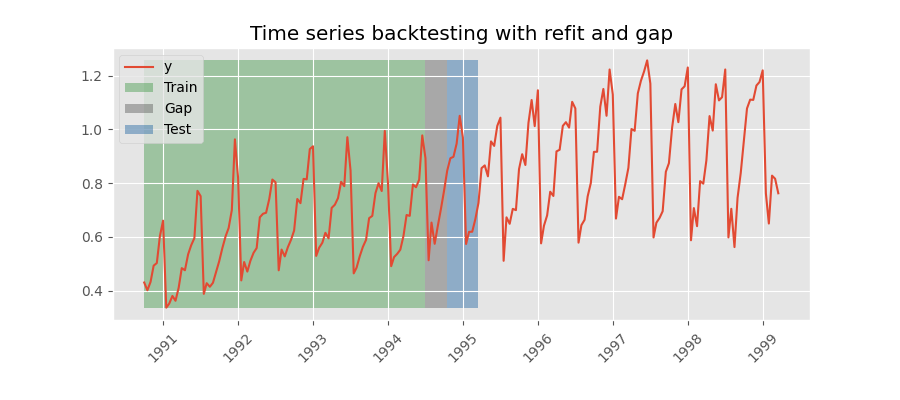

In [12]:
custom_plot(df_plot, folds[0], 'Time series backtesting with refit and gap')

In [18]:
duracion_gif = 700 # miliseconds
title = 'Time series backtesting no refit'

folds = _create_backtesting_folds(
            data                  = data_gif['y'],
            test_size             = 10,
            initial_train_size    = 96,
            gap                   = 0,
            refit                 = False,
            fixed_train_size      = False,
            allow_incomplete_fold = True,
            return_all_indexes    = False,
            verbose               = False  
        )

frames = []
for fold in tqdm(folds):

    frame = custom_plot(df_plot, fold, title)
    frames.append(frame)


name = 'backtesting_no_refit'

gif.save(frames, f'./{name}.gif', duration=duracion_gif)

100%|██████████| 11/11 [00:00<00:00, 11.26it/s]
